### This (will) be the most up to date classifier, with everything from transfer_classifier_resnet_multi.ipynb being moved to here and cleaned up

In [1]:
import os
import tempfile
import time
import pickle as pkl;

import numpy as np
import matplotlib.pyplot as plt;

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from PIL import Image
from sklearn.metrics import roc_auc_score

from util.train_methods import (GetLoader,
                                load_old_weights,
                                hard_binary_accuracy,
                                train,
                                test,
                                display_roc_curve)

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

## Parameters

In [2]:
n_epochs = 40
patience_limit = 20
patience = 0
batch_size_train = 16# was 64
batch_size_test = 16
learning_rate = 0.0005
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000
retrain_old_model = False

model_name = '6_disease_aug_test_3'
model_path = './data/saved_models/' + model_name + '.pth'

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }

dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4, 'No Finding': 5}

### Load in dataset

In [4]:
pkl_load = open('dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [5]:
transforms = [torchvision.transforms.RandomHorizontalFlip(p=0.5),
              torchvision.transforms.CenterCrop(1000), # removing edges since model sometimes learns weird edge features
              torchvision.transforms.RandomRotation(5),              
              torchvision.transforms.ToTensor()]

dataset_train = GetLoader(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 'train', transforms)
dataset_valid = GetLoader(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 'test', transforms)
dataset_test = GetLoader(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 'valid', transforms)
print('train imgs:', len(dataset_train))
print('test imgs:', len(dataset_valid))
print('valid imgs:', len(dataset_test))

train imgs: 22220
test imgs: 2778
valid imgs: 2777


In [6]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_test, shuffle=True, num_workers=1)
print('train batches:', len(dataset_train))
print('test batches:', len(dataset_valid))
print('valid batches:', len(dataset_test))

train batches: 22220
test batches: 2778
valid batches: 2777


In [7]:
network = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

network.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid(),
])

network = torch.nn.DataParallel(network)
network.cuda();

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [8]:
if retrain_old_model:
    load_old_weights(network, model_path)

In [9]:
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11179590


In [10]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
GeForce RTX 2080 Ti
True


Starting Training...
-----------Epoch 1 (time = 741.44 s  aka   12.36  mins) ----------------
Train set: Avg. loss: 0.0323,  Accuracy: 103056/133320 (77.30%)
Test set:  Avg. loss: 0.0323, Accuracy: 12716/16662 (76.32%)

Epoch 1 --- saving new best model: test loss = 0.03225100791916765



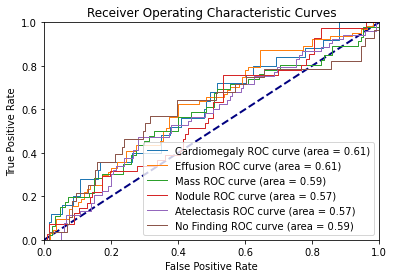

-----------Epoch 2 (time = 720.26 s  aka   12.0  mins) ----------------
Train set: Avg. loss: 0.0318,  Accuracy: 103227/133320 (77.43%)
Test set:  Avg. loss: 0.0322, Accuracy: 12751/16662 (76.53%)

Epoch 2 --- saving new best model: test loss = 0.0321542599035063

-----------Epoch 3 (time = 721.69 s  aka   12.03  mins) ----------------
Train set: Avg. loss: 0.0316,  Accuracy: 103261/133320 (77.45%)
Test set:  Avg. loss: 0.0317, Accuracy: 12817/16662 (76.92%)

Epoch 3 --- saving new best model: test loss = 0.03173470697312177

-----------Epoch 4 (time = 720.64 s  aka   12.01  mins) ----------------
Train set: Avg. loss: 0.0313,  Accuracy: 103444/133320 (77.59%)
Test set:  Avg. loss: 0.0319, Accuracy: 12813/16662 (76.90%)

-----------Epoch 5 (time = 720.98 s  aka   12.02  mins) ----------------
Train set: Avg. loss: 0.0314,  Accuracy: 103465/133320 (77.61%)
Test set:  Avg. loss: 0.0322, Accuracy: 12805/16662 (76.85%)

-----------Epoch 6 (time = 720.39 s  aka   12.01  mins) --------------

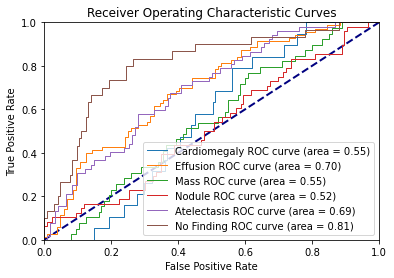

-----------Epoch 11 (time = 718.06 s  aka   11.97  mins) ----------------
Train set: Avg. loss: 0.0309,  Accuracy: 103959/133320 (77.98%)
Test set:  Avg. loss: 0.0323, Accuracy: 12786/16662 (76.74%)

-----------Epoch 12 (time = 718.17 s  aka   11.97  mins) ----------------
Train set: Avg. loss: 0.0309,  Accuracy: 103861/133320 (77.90%)
Test set:  Avg. loss: 0.0314, Accuracy: 12788/16662 (76.75%)

Epoch 12 --- saving new best model: test loss = 0.03135594167885767

-----------Epoch 13 (time = 718.68 s  aka   11.98  mins) ----------------
Train set: Avg. loss: 0.0306,  Accuracy: 104086/133320 (78.07%)
Test set:  Avg. loss: 0.0312, Accuracy: 12900/16662 (77.42%)

Epoch 13 --- saving new best model: test loss = 0.03122321049543633

-----------Epoch 14 (time = 717.13 s  aka   11.95  mins) ----------------
Train set: Avg. loss: 0.0301,  Accuracy: 104451/133320 (78.35%)
Test set:  Avg. loss: 0.0314, Accuracy: 12739/16662 (76.46%)

-----------Epoch 15 (time = 716.73 s  aka   11.95  mins) -----

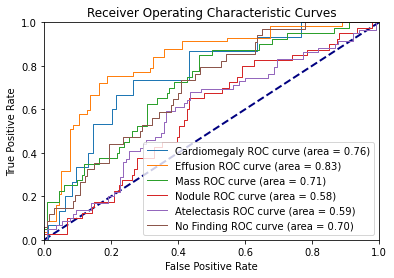

-----------Epoch 21 (time = 742.36 s  aka   12.37  mins) ----------------
Train set: Avg. loss: 0.0294,  Accuracy: 104908/133320 (78.69%)
Test set:  Avg. loss: 0.0311, Accuracy: 12836/16662 (77.04%)

Epoch 21 --- saving new best model: test loss = 0.031100462447723437

-----------Epoch 22 (time = 735.71 s  aka   12.26  mins) ----------------
Train set: Avg. loss: 0.0288,  Accuracy: 105308/133320 (78.99%)
Test set:  Avg. loss: 0.0293, Accuracy: 13034/16662 (78.23%)

Epoch 22 --- saving new best model: test loss = 0.029332746173544175

-----------Epoch 23 (time = 722.06 s  aka   12.03  mins) ----------------
Train set: Avg. loss: 0.0284,  Accuracy: 105599/133320 (79.21%)
Test set:  Avg. loss: 0.0290, Accuracy: 13103/16662 (78.64%)

Epoch 23 --- saving new best model: test loss = 0.028951409101571846

-----------Epoch 24 (time = 722.71 s  aka   12.05  mins) ----------------
Train set: Avg. loss: 0.0279,  Accuracy: 106152/133320 (79.62%)
Test set:  Avg. loss: 0.0299, Accuracy: 13007/16662 

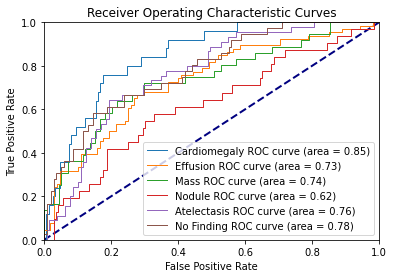

-----------Epoch 31 (time = 724.44 s  aka   12.07  mins) ----------------
Train set: Avg. loss: 0.0257,  Accuracy: 108645/133320 (81.49%)
Test set:  Avg. loss: 0.0283, Accuracy: 13209/16662 (79.28%)

Epoch 31 --- saving new best model: test loss = 0.028310805270127182

-----------Epoch 32 (time = 726.31 s  aka   12.11  mins) ----------------
Train set: Avg. loss: 0.0254,  Accuracy: 108966/133320 (81.73%)
Test set:  Avg. loss: 0.0298, Accuracy: 13005/16662 (78.05%)

Epoch 32 --- saving new best model: test loss = 0.02984932108899985

-----------Epoch 33 (time = 724.99 s  aka   12.08  mins) ----------------
Train set: Avg. loss: 0.0251,  Accuracy: 109179/133320 (81.89%)
Test set:  Avg. loss: 0.0285, Accuracy: 13202/16662 (79.23%)

Epoch 33 --- saving new best model: test loss = 0.028458728915315933

-----------Epoch 34 (time = 725.3 s  aka   12.09  mins) ----------------
Train set: Avg. loss: 0.0249,  Accuracy: 109637/133320 (82.24%)
Test set:  Avg. loss: 0.0276, Accuracy: 13291/16662 (7

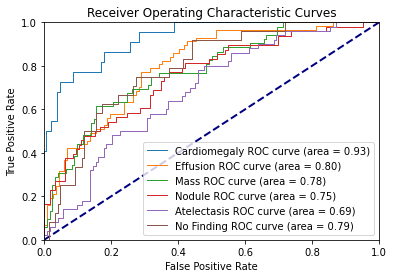

Reloading best model from epoch 40
Training complete (time = 29396.02 s)
Saved model to ./data/saved_models/6_disease_aug_test_3.pth


In [11]:
print("Starting Training...")
begin_time = time.time()

min_loss_test = 999

train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_true_pos = []
train_false_pos = []
train_true_neg = []
train_false_neg = []

test_true_pos = []
test_false_pos = []
test_true_neg = []
test_false_neg = []

best_model_file = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
torch.save(network.state_dict(), best_model_file.name)



for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    network.load_state_dict(torch.load(best_model_file.name))

    loss_train, true_pos_train, false_pos_train, true_neg_train, false_neg_train = train(epoch,
                                                                                         network,
                                                                                         train_loader,
                                                                                         optimizer,
                                                                                         batch_size_train)
    loss_test, true_pos_test, false_pos_test, true_neg_test, false_neg_test = test(network,
                                                                                   test_loader,
                                                                                   batch_size_test)
    
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    n_correct_train = true_pos_train + true_neg_train
    n_correct_test = true_pos_test + true_neg_test
    
    acc_train = 100. * n_correct_train / (n_correct_train + false_pos_train + false_neg_train)
    acc_test = 100. * n_correct_test / (n_correct_test + false_pos_test + false_neg_test)
    
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    
    train_true_pos.append(true_pos_train)
    train_false_pos.append(false_pos_train)
    train_true_neg.append(true_neg_train)
    train_false_neg.append(false_neg_train)

    test_true_pos.append(true_pos_test)
    test_false_pos.append(false_pos_test)
    test_true_neg.append(true_neg_test)
    test_false_neg.append(false_neg_test)
        
    auc_train = roc_auc_score

        
    elapsed_time = time.time() - start_time
    
    print("-----------Epoch " + str(epoch) + " (time =", round(elapsed_time, 2), "s  aka  ", round(elapsed_time / 60, 2), " mins) ----------------")
    print('Train set: Avg. loss: {:.4f},  Accuracy: {}/{} ({:.2f}%)'.format(
        loss_train, n_correct_train, (n_correct_train + false_pos_train + false_neg_train), acc_train))
 
    print('Test set:  Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss_test, n_correct_test, (n_correct_test + false_pos_test + false_neg_test), acc_test))    
    
    if loss_test < min_loss_test or (epoch > 20 and loss_test < min_loss_test * 1.2):
        min_loss_test = loss_test
        patience = 0
        best_epoch = epoch
        
        print('Epoch {} --- saving new best model: test loss = {}\n'.format(epoch, loss_test))
        torch.save(network.state_dict(), best_model_file.name)
        torch.save(network.state_dict(), os.path.join(model_path)) # guarantees best one saved if program crashes
    else:
        patience += 1
        
    if patience == patience_limit:
        print('Breaking on patience={}'.format(patience))
        break
        
    if epoch % 10 == 0 or epoch == 1:
        display_roc_curve(valid_loader, network, dis_small_map, batch_size_test)
        

print('Reloading best model from epoch {}'.format(best_epoch))
network.load_state_dict(torch.load(best_model_file.name))

end_time = time.time() - begin_time

print("Training complete (time =", round(end_time, 2), "s)")
torch.save(network.state_dict(), 
           os.path.join(model_path))
print("Saved model to {}".format(model_path))

    

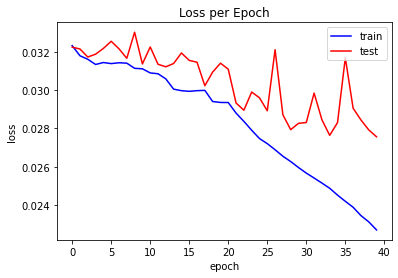

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Loss per Epoch")
plt.plot(train_losses, "-b",  label="train")
plt.plot(test_losses, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")

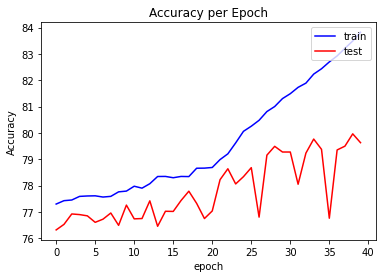

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Accuracy per Epoch")
plt.plot(train_acc, "-b", label="train")
plt.plot(test_acc, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")

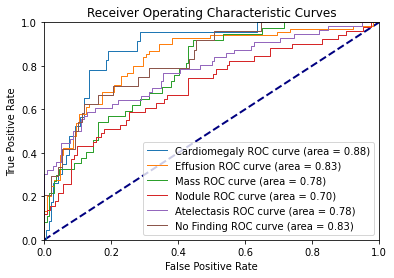

In [14]:
display_roc_curve(valid_loader, network, dis_small_map, batch_size_test)

In [15]:
plt.hist(preds['Cardiomegaly'], label='Cardiomegaly')
plt.hist(preds['Effusion'], label='Effusion')
plt.hist(preds['Nodule'], label='Nodule')
plt.hist(preds['Mass'], label='Mass')
plt.hist(preds['Atelectasis'], label='Atelectasis')
plt.legend()

NameError: name 'preds' is not defined